<a href="https://colab.research.google.com/github/veyselalevcan/Time_Series/blob/main/Portugal_Electricity_Comsumption_Time_Series_Without_Pruning_Embeeded_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Veriyi yükle
data = pd.read_csv('time_series_60min_singleindex.csv')

# Portekiz'in elektrik tüketimi verisini filtrele
data = data[['utc_timestamp', 'PT_load_actual_entsoe_transparency']]
data = data.dropna()  # Eksik verileri kaldır

# Zaman damgasını tarih formuna çevir ve indeksle
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Ölçekleme (LSTM'in daha iyi öğrenmesi için veriyi 0-1 aralığına çek)
scaler = MinMaxScaler()
data['scaled_load'] = scaler.fit_transform(data[['PT_load_actual_entsoe_transparency']])

# LSTM için ardışık veri kümeleri oluştur
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # 24 saatlik geçmiş veriyi kullanarak tahmin yapalım
X, y = create_sequences(data['scaled_load'].values, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM için 3 boyutlu veri gereklidir


In [ ]:
# Model tanımı
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=32)  # Eğitim (küçük bir veri setiyle hızlı sonuç almak için düşük epoch)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0302
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0015
Epoch 3/10
 696/1080 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0013

KeyboardInterrupt: 

In [ ]:
# Tahmin yapmak için en son veri dizisini alalım
last_sequence = X[-1]  # En son ardışık veri kümesi

# Tahmin
predicted_load = model.predict(last_sequence.reshape(1, seq_length, 1))

# Tahmini orijinal ölçeğe dönüştür
predicted_load = scaler.inverse_transform(predicted_load)
print(f"Predicted load for next hour: {predicted_load[0][0]:.2f} MW")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Predicted load for next hour: 5160.79 MW


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Veri yükleme
data = pd.read_csv('time_series_60min_singleindex.csv')

# Veriyi filtrele ve işleme
data = data[['utc_timestamp', 'PT_load_actual_entsoe_transparency']].dropna()
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Veriyi ölçekleme
scaler = MinMaxScaler()
data['scaled_load'] = scaler.fit_transform(data[['PT_load_actual_entsoe_transparency']])

# LSTM için ardışık veri kümeleri oluşturma
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(data['scaled_load'].values, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Veriyi eğitim ve test olarak ayır
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model tanımlama ve eğitim
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0203 - val_loss: 0.0012
Epoch 2/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0012 - val_loss: 9.3084e-04
Epoch 3/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 9.9066e-04 - val_loss: 7.3542e-04
Epoch 5/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 8.1984e-04 - val_loss: 6.9779e-04
Epoch 6/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 7.3970e-04 - val_loss: 6.3609e-04
Epoch 7/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 6.8016e-04 - val_loss: 5.8101e-04
Epoch 8/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 6.2759e-04 - val_loss: 6.4458e-04
Epoch 9/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 6.2102e-04 - val_loss: 5.0499e-04
Epoch 10/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 5.6056e-04 - val_loss: 5.2709e-04
Epoch 11/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 13s 13m

315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


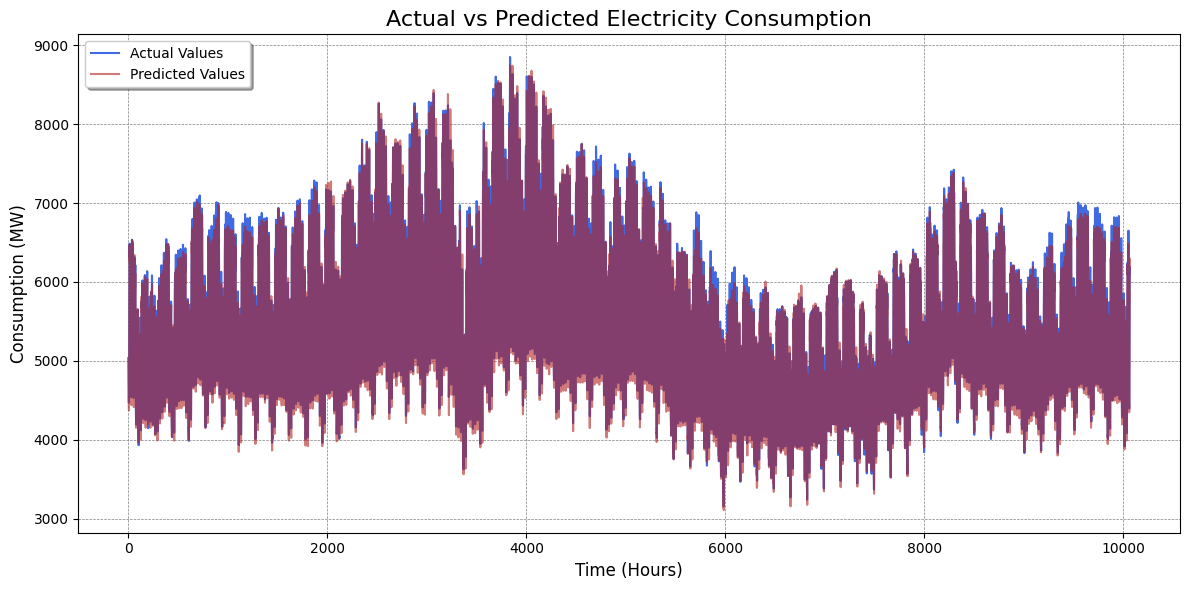

11079.508873640902 78.08951325323737


In [ ]:
# Model doğruluğunu ölçme
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='royalblue', label='Actual Values', linewidth=1.5)
plt.plot(y_pred_rescaled, color='firebrick', label='Predicted Values', alpha=0.6, linewidth=1.5)

# Title and labels
plt.title("Actual vs Predicted Electricity Consumption", fontsize=16)
plt.xlabel("Time (Hours)", fontsize=12)
plt.ylabel("Consumption (MW)", fontsize=12)

# Adding a grid for better readability
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='gray')

# Enhancing the legend
plt.legend(loc="upper left", fontsize=10, frameon=True, shadow=True)

# Display the plot
plt.tight_layout()
plt.show()

print(mse, mae)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
data = pd.read_csv('time_series_60min_singleindex.csv')
# Portekiz'in elektrik tüketimi verisini filtrele
data = data[['utc_timestamp', 'PT_load_actual_entsoe_transparency']]
data = data.dropna()  # Eksik verileri kaldır

# Zaman damgasını tarih formuna çevir ve indeksle
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)
data.head()

# Ölçekleme (LSTM'in daha iyi öğrenmesi için veriyi 0-1 aralığına çek)
scaler = MinMaxScaler()
data['scaled_demand'] = scaler.fit_transform(data[['PT_load_actual_entsoe_transparency']])

# Prepare data for LSTM
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Using 24-hour sequences
X, y = create_sequences(data['scaled_demand'].values, seq_length)

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32)

# Forecast function
def forecast(model, data, seq_length=24):
    forecasted = []
    for i in range(len(data) - seq_length):
        pred = model.predict(data[i:i+seq_length].reshape(1, seq_length, 1))
        forecasted.append(pred[0, 0])
    return forecasted





Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0173
Epoch 2/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0010
Epoch 3/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8.3926e-04
Epoch 4/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 7.9282e-04
Epoch 5/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 6.9048e-04
Epoch 6/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 6.5607e-04
Epoch 7/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5.7939e-04
Epoch 8/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 5.2654e-04
Epoch 9/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 7.5312e-04
Epoch 10/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.0359e-04
Epoch 11/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 5.5446e-04
Epoch 12/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 4.6655e-04
Epoch 13/20
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 4.3260e-04
Epoch 14/20
1574/1574 ━━━━━━━━━━━━━━━━━━

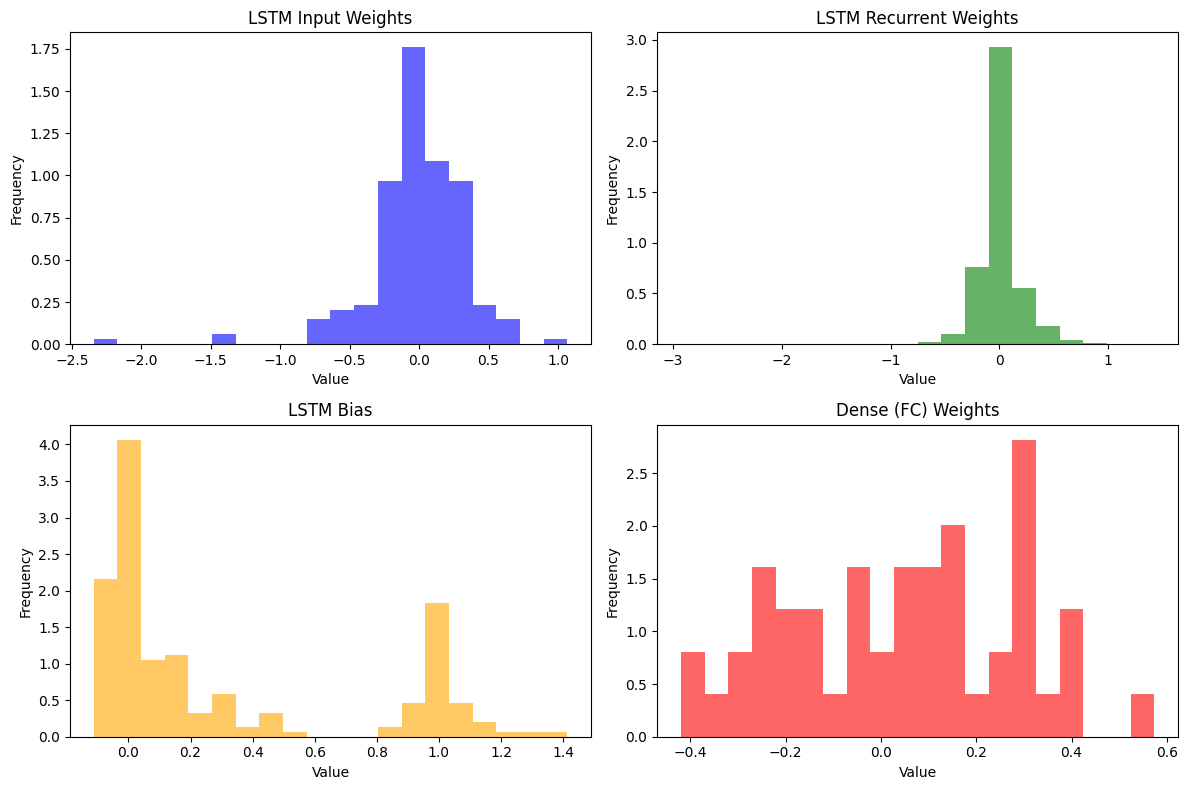

In [ ]:
# Collect weights and biases for plotting
# Access the LSTM layer by index
lstm_weights = model.layers[0].get_weights()[0].flatten()  # Input weights to LSTM layer
lstm_recurrent_weights = model.layers[0].get_weights()[1].flatten() # Recurrent weights to LSTM layer
lstm_bias = model.layers[0].get_weights()[2].flatten()  # Biases for the LSTM layer

# Access the Dense layer (which is the fully connected layer in this case)
dense_weights = model.layers[1].get_weights()[0].flatten()  # Weights for the Dense layer
dense_bias = model.layers[1].get_weights()[1].flatten()  # Biases for the Dense layer


# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

# Histogram for LSTM input weights
axes[0].hist(lstm_weights, bins=20, density=True, alpha=0.6, color='blue')
axes[0].set_title('LSTM Input Weights')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Histogram for LSTM recurrent weights
axes[1].hist(lstm_recurrent_weights, bins=20, density=True, alpha=0.6, color='green')
axes[1].set_title('LSTM Recurrent Weights')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Histogram for LSTM bias
axes[2].hist(lstm_bias, bins=20, density=True, alpha=0.6, color='orange')
axes[2].set_title('LSTM Bias')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Histogram for Dense (FC) weights
axes[3].hist(dense_weights, bins=20, density=True, alpha=0.6, color='red') # Changed to dense_weights
axes[3].set_title('Dense (FC) Weights') # Changed title
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import random
import numpy as np

class EnergyManagementAgent:
    def __init__(self, action_space, discount_factor=0.9, learning_rate=0.01, epsilon=0.1):
        self.q_table = {}  # Q-learning table
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # Probability of choosing a random action
        self.action_space = action_space  # Possible actions

    def get_action(self, state):
        # ε-greedy policy for action selection
        if state not in self.q_table:
            self.q_table[state] = [0] * len(self.action_space)

        if random.uniform(0, 1) < self.epsilon:  # Exploration
            return random.choice(range(len(self.action_space)))
        else:  # Exploitation
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = [0] * len(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = [0] * len(self.action_space)

        best_next_action = max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (
            reward + self.discount_factor * best_next_action - self.q_table[state][action]
        )

    def calculate_reward(self, action, forecasted_demand):
        # Placeholder reward function
        # Assume reducing load is beneficial if demand is high, and penalize increased load during peak
        if forecasted_demand > 6000:  # High demand threshold
            return -abs(action)  # Penalty for any load change
        else:
            return action  # Reward for reducing load

# Example usage
agent = EnergyManagementAgent(action_space=[-1, 0, 1], epsilon=0.2)  # Actions: reduce, maintain, increase load
forecasted_demand = 5716  # Replace with actual forecasted demand from an LSTM model
hour_of_day = 12  # Current hour of the day

state = (forecasted_demand, hour_of_day)
action = agent.get_action(state)
reward = agent.calculate_reward(action, forecasted_demand)
next_state = (forecasted_demand + random.randint(-100, 100), (hour_of_day + 1) % 24)

agent.update_q_table(state, action, reward, next_state)

print("Selected action:", action)
print("Reward:", reward)


Selected action: 1
Reward: 1
